# Facies classification using Machine Learning

#### Joshua Poirier, [NEOS](https://www.neosgeo.com/)

Some sort of introduction

In [21]:
# read data and display first few rows and dimensions
fname <- "../facies_vectors.csv"
training_data <- read.csv(fname, colClasses=c(rep("factor",3), rep("numeric",8)))
head(training_data)
dim(training_data)
levels(training_data$Well.Name)

Facies,Formation,Well.Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915
3,A1 SH,SHRIMPLIN,2795.5,73.97,0.636,14.0,13.385,3.6,1,0.894


[1] 4149   11

[1] "ALEXANDER D"     "CHURCHMAN BIBLE" "CROSS H CATTLE"  "KIMZEY A"       
 [5] "LUKE G U"        "NEWBY"           "NOLAN"           "Recruit F9"     
 [9] "SHANKLE"         "SHRIMPLIN"

remove a single well as a blind tester

In [26]:
# training and validation maybe?
blind <- training_data[training_data$Well.Name == 'NEWBY',]
training_data <- training_data[training_data$Well.Name != 'NEWBY',]

This data is from the Panoma Council Grove Field (predominantly gas reservoir) over 2700 sq mi in SW Kansas.  The dataset is from nine wells with 4149 samples.  Each sample consists of seven predictor variables and a rock facies.  The validation (test) data have 830 samples from two wells having the same seven predictor variables.  Facies are based on examination of cores from the nine wells taken vertically at half-foot intervals.  The predictor variables include five wireline log measurements and two geologic constraining variables that are derived from geologic knowledge and are sampled at the same half-foot rate.  

The seven predictor variables are:

* GR - Gamma ray  
* ILD_log10 - Resistivity logging  
* PE - Photoelectric effect (some wells are missing this log)  
* DeltaPhi - Neutron-density porosity difference  
* PHIND - Average neutron-density porosity  

The two geologic constraining variables are:  

* NM_M - nonmarine-marine indicator  
* RELPOS - Relative position  

The nine discrete facies (classes of rock) are:  

1. Nonmarine sandstone  
2. Nonmarine coarse siltstone  
3. Nonmarine fine siltstone  
4. Marine siltstone and shale  
5. Mudstone (limestone)  
6. Wackestone (limestone)  
7. Dolomite  
8. Pckstone-grainstone (limestone)  
9. Phylloid-algal bafflestone (limestone)  

These facies are not discrete and can gradually blend into one another.  Some have neighboring facies that are rather close.  Mislabeling within these neighboring facies can be expected to occur.  The following table lists the facies, their abbreviated labels, and their approximate neighbors.  


Facies |Label| Adjacent Facies
:---: | :---: |:--:
1 |SS| 2
2 |CSiS| 1,3
3 |FSiS| 2
4 |SiSh| 5
5 |MS| 4,6
6 |WS| 5,7
7 |D| 6,8
8 |PS| 6,7,9
9 |BS| 7,8

Now let's take a quick look at the well names.

In [28]:
unique(training_data$Well.Name)

[1] SHRIMPLIN       ALEXANDER D     SHANKLE         LUKE G U       
[5] KIMZEY A        CROSS H CATTLE  NOLAN           Recruit F9     
[9] CHURCHMAN BIBLE
10 Levels: ALEXANDER D CHURCHMAN BIBLE CROSS H CATTLE KIMZEY A ... SHRIMPLIN

This shows the names of the ten training wells in the Council Grove reservoir.  Data has been recruited into pseudo-well *Recruit F9* to better represent *facies 9*, the **Phylloid-algal bafflestone**.  

Now let's define a colormap for the facies such that they are represented by consistent colors in this tutorial.  We'll also take a peek at the statistical distribution of the input variables.

In [135]:
# 1=sandstone, 2=c_siltstone, 3=f_siltstone, 4=marine_silt_shale, 5=mudstone, 
# 6=wackestone, 7=dolomite, 8=packestone, 9=bafflestone

facies_colors <- c('#F4D03F', '#F5B041', '#DC7633', '#6E2C00', '#1B4F72', '#2E86C1', '#AED6F1', '#A569BD', '#196F3D')
facies_labels <- c('SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS')

summary(training_data)
unique(training_data$Facies)

     Facies      Formation             Well.Name       Depth     
 2      :842   C LM   : 594   CROSS H CATTLE:501   Min.   :2574  
 3      :700   A1 LM  : 509   SHRIMPLIN     :471   1st Qu.:2806  
 8      :630   A1 SH  : 379   ALEXANDER D   :466   Median :2931  
 6      :486   C SH   : 351   LUKE G U      :461   Mean   :2903  
 1      :268   B5 LM  : 319   SHANKLE       :449   3rd Qu.:3008  
 5      :268   B1 SH  : 303   KIMZEY A      :439   Max.   :3138  
 (Other):492   (Other):1231   (Other)       :899                 
       GR           ILD_log10           DeltaPHI           PHIND      
 Min.   : 10.15   Min.   :-0.02595   Min.   :-21.832   Min.   : 0.55  
 1st Qu.: 45.57   1st Qu.: 0.48900   1st Qu.:  1.700   1st Qu.: 8.55  
 Median : 65.68   Median : 0.63500   Median :  4.369   Median :12.17  
 Mean   : 65.46   Mean   : 0.65765   Mean   :  4.519   Mean   :13.40  
 3rd Qu.: 80.20   3rd Qu.: 0.82900   3rd Qu.:  7.600   3rd Qu.:16.24  
 Max.   :361.15   Max.   : 1.80000   Max.   : 

[1] 3 2 8 6 7 4 5 9 1
Levels: 1 2 3 4 5 6 7 8 9

Looking at the statistical summary of the input variables, it can be seen that all but the **PE** inputs have no **NA**'s listed.  For this tutorial, we will drop the feature vectors that do not have a valid **PE** entry.

In [32]:
PE_mask <- training_data[complete.cases(training_data),]
dim(PE_mask)

[1] 2769   11

Out of the original 4149 samples, we will be training our model on 2769 samples.  Now let's build some familiar log plots!

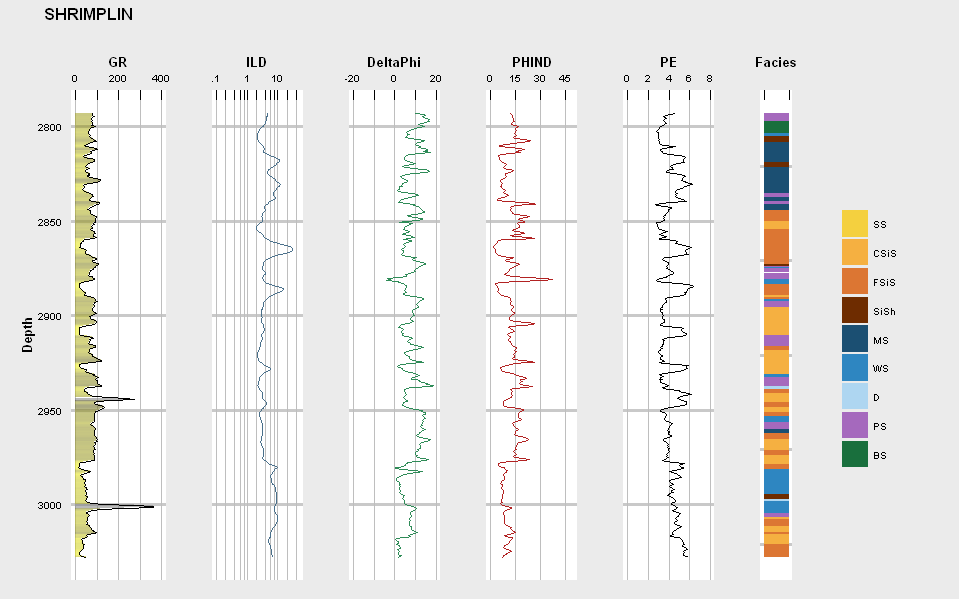

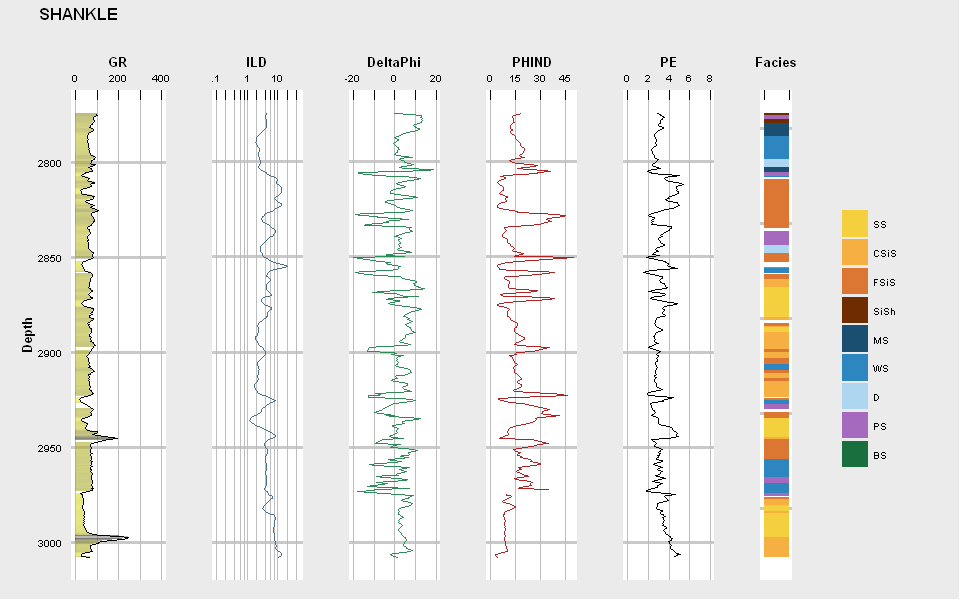

In [235]:
library(repr)
library(ggplot2)
library(ggthemes)
library(cowplot)

options(repr.plot.width=8, repr.plot.height=5)

logplot <- function(data) {
    # GR gamma ray track
    g1 <- ggplot(data) + theme_economist_white(gray_bg=T) + 
        scale_y_continuous(lim=c(0,400), breaks=seq(0,400,100), labels=c("0"="0","100"="","200"="200","300"="","400"="400")) +
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="Depth", y="GR") +
        geom_bar(stat="identity", data=data, aes(x=Depth, y=GR, fill=GR, alpha=0.5), width=0.5) +
        geom_line(aes(x=Depth, y=GR), lwd=.5, col='black') +
        scale_fill_continuous(limits=c(0,225), low="yellow", high="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.5), legend.position="none",
             axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"))
    g1 <- switch_axis_position(g1, 'x')
    
    # ILD resistivity track (transform it back to actual units)
    g2 <- ggplot(data) + theme_economist_white(gray_bg=T) +
        scale_y_log10(lim=c(0.1,50), breaks=c(.1,.2,.4,.6,.8,1,2,4,6,8,10,20,40), 
                      labels=c(".1"=".1",".2"="",".4"="",".6"="",".8"="",
                               "1"="1","2"="","4"="","6"="","8"="","10"="10",
                              "20"="","40"="")) + 
        scale_x_continuous(trans="reverse") + 
        coord_flip() + labs(title="", x="", y="ILD") +
        geom_line(aes(x=Depth, y=10^ILD_log10), lwd=.5, col="skyblue4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    g2 <- switch_axis_position(g2, 'x')
    
    # DeltaPhi track
    g3 <- ggplot(data) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-20,20), breaks=seq(-20,20,10),labels=c("-20"="-20","-10"="","0"="0","10"="","20"="20")) + 
        scale_x_continuous(trans="reverse") + coord_flip() + labs(title="", x="", y="DeltaPhi") +
        geom_line(aes(x=Depth, y=DeltaPHI), lwd=.5, col="seagreen4") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    g3 <- switch_axis_position(g3, 'x')
    
    # PHIND neutron porosity track
    g4 <- ggplot(data) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(0,50), breaks=c(0,15,30,45)) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="PHIND") +
        geom_line(aes(x=Depth, y=PHIND), lwd=.5, col="firebrick") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    g4 <- switch_axis_position(g4, 'x')
    
    # PE photoelectric effect track
    g5 <- ggplot(data) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(0,8), breaks=c(0,2,4,6,8)) + scale_x_continuous(trans="reverse") +
        coord_flip() + labs(title="", x="", y="PE") +
        geom_line(aes(x=Depth, y=PE), lwd=.5, col="black") +
        theme(panel.grid.major.x = element_line(colour="gray", size=0.25), legend.position="none", 
              axis.text=element_text(size=6), axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank())
    g5 <- switch_axis_position(g5, 'x')
    
    # Facies track
    data$ones <- rep(1, nrow(data))
    g6 <- ggplot(data) + theme_economist_white(gray_bg=T) +
        scale_y_continuous(lim=c(-0.1,1.1), breaks=c(0,1), labels=c("0"="", "1"="")) +
        coord_flip() + labs(title="", x="", y="Facies") +
        geom_bar(stat="identity", data=data, aes(x=Depth, y=ones, fill=Facies), width=0.5) +
        scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels) +
        theme(legend.position="right", legend.text=element_text(size=6), legend.title=element_blank()) +
        theme(axis.title=element_text(size=8,face="bold"), axis.text.y=element_blank(), axis.text.x=element_text(size=6))
    g6 <- switch_axis_position(g6, 'x')

    # bring all the tracks together as a grid and draw
    g <- plot_grid(g1, g2, g3, g4, g5, g6, ncol=6, rel_widths=c(4,3,3,3,3,5))
    ggdraw() + draw_plot(g, width=1, height=1) + draw_plot_label(data$Well.Name[1], size=10)
}

# plot logs for the Shrimplin and Shankle wells
logplot(PE_mask[PE_mask$Well.Name == "SHRIMPLIN",])
logplot(PE_mask[PE_mask$Well.Name == "SHANKLE",])

We can also look at how the different facies are represented in the entire training data set.  Let's make a histogram!


  1   2   3   4   5   6   7   8   9 
259 640 535 126 189 366  82 442 130 

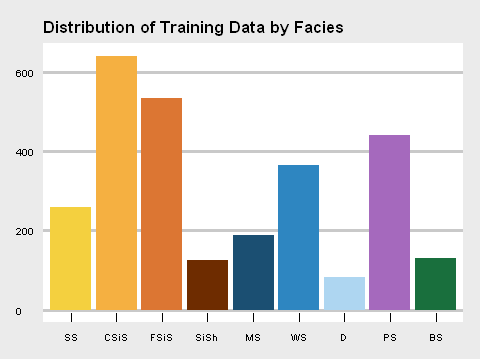

In [239]:
options(repr.plot.width=4, repr.plot.height=3)

table(PE_mask$Facies)

# build histogram of facies in training data
g <- ggplot(PE_mask) + theme_economist_white(gray_bg=T) +
    geom_bar(aes(x=Facies, fill=Facies)) + labs(title="Distribution of Training Data by Facies", x="", y="") +
    scale_x_discrete(labels=facies_labels) +
    scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels) +
    theme(legend.position="none", legend.title=element_blank(), legend.text=element_text(size=6),
         axis.text=element_text(size=6), plot.title=element_text(size=10), axis.title=element_blank())
g

This shows the distribution of facies in the training data.  **Dolomite** (facies 7) has the fewest observations with 141; while **Bafflestone** (facies 9) has 185 (second lowest).  Depending on the performance of the classifier we are going to train, we may consider acquiring more observations of these facies.  

Crossplots are a familiar tool in the geosciences to visualize how two properties vary with rock type.  This dataset contains five log variables, and a pairs plot can quickly visualize the variation between these five variables.

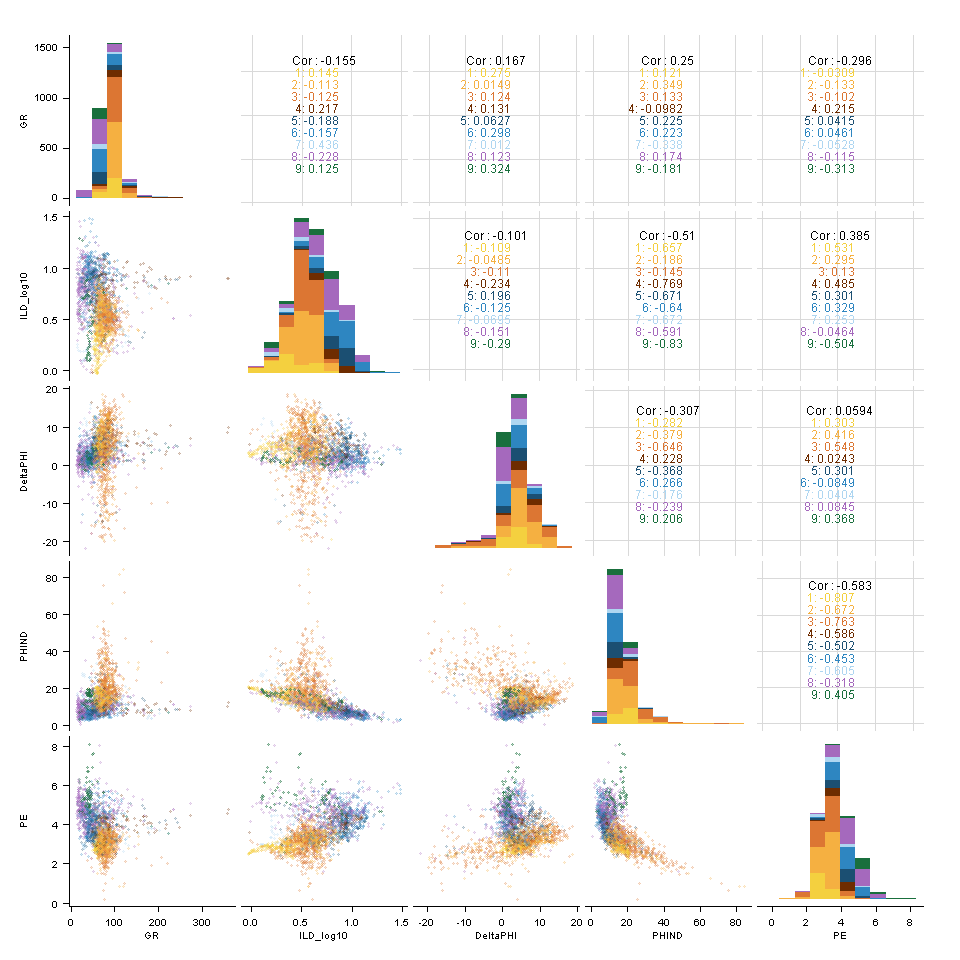

In [278]:
library(GGally)

options(repr.plot.width=8, repr.plot.height=8)

# build pairs plot
p <- ggpairs(PE_mask, aes(colour=Facies), columns=c("GR", "ILD_log10", "DeltaPHI", "PHIND", "PE"), 
             lower=list(continuous=wrap("points",size=.5,alpha=.2)),
             diag=list(continuous=wrap("barDiag",bins=10)), 
             upper=list(continuous=wrap("cor", size=2.5))) + 
            theme(axis.text=element_text(size=6), axis.title=element_text(size=6))

# modify colors to be consistent 
for (i in 1:p$nrow) {
    for (j in 1:p$ncol) {
        p[i,j] <- p[i,j] + scale_color_manual(values=facies_colors, drop=F, labels=facies_labels) + 
                scale_fill_manual(values=facies_colors, drop=F, labels=facies_labels)
    }
}

p